In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from typing import Dict
df = pd.read_csv("../data/Detalles_clientes.csv",index_col=False)

In [2]:
df['valor'] = df['valor'].astype(str).str.replace("'", "")
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
df['clase'] = df['clase'].astype('category')
df['fecha_efectiva'] = pd.to_datetime(df['fecha_efectiva'], format='%Y%m%d')

2025-08-15 11:40:56,710 - INFO - Inicio del proceso de segmentación de clientes.
2025-08-15 11:40:56,712 - INFO - Iniciando la ingeniería de características (Feature Engineering)...
C:\Users\BRAYAN\AppData\Local\Temp\ipykernel_12940\1399326212.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df.pivot_table(
C:\Users\BRAYAN\AppData\Local\Temp\ipykernel_12940\1399326212.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df.pivot_table(
2025-08-15 11:40:56,747 - INFO - Ingeniería de características completada.
2025-08-15 11:40:56,751 - INFO - Determinando el número óptimo de clusters (k)...


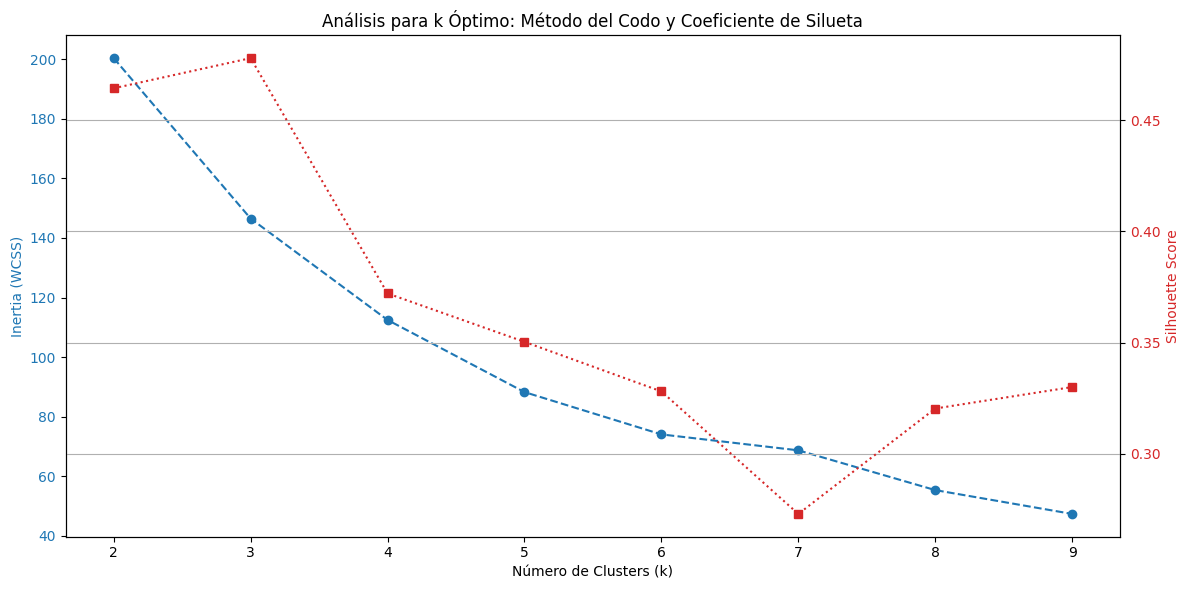

2025-08-15 11:41:00,116 - INFO - Entrenando modelo K-Means con k=4...
2025-08-15 11:41:00,183 - INFO - Perfilando los clusters...


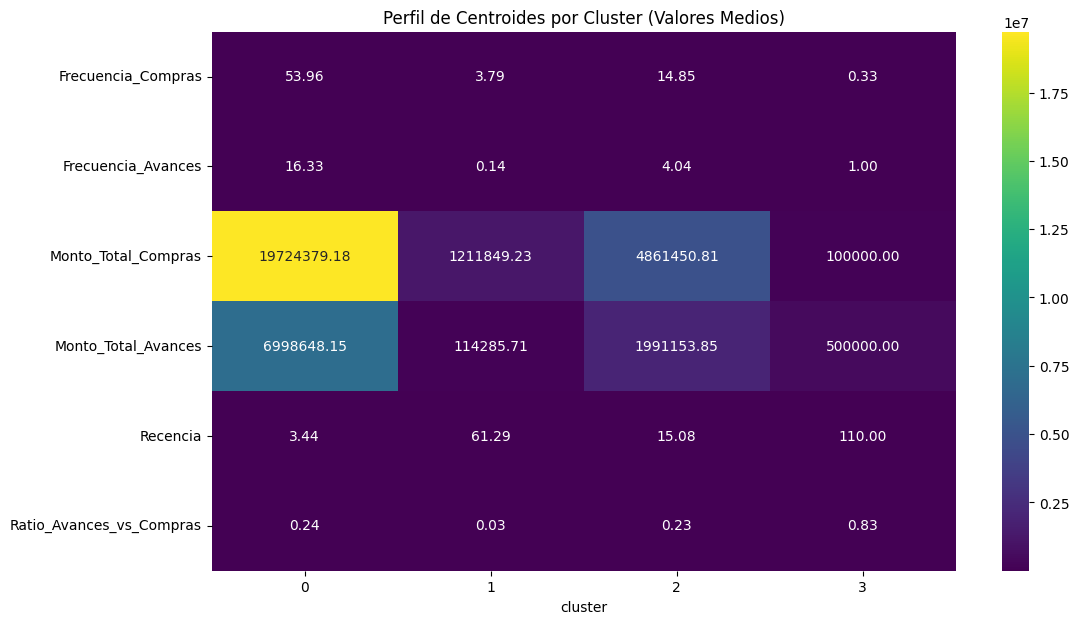

2025-08-15 11:41:00,386 - INFO - Asignación de estrategia de descuento completada.
2025-08-15 11:41:00,398 - INFO - Generando entregable final en '../data/Estrategia_Segmentacion_Clientes.csv'...
2025-08-15 11:41:00,411 - INFO - Archivo guardado exitosamente.



--- Vista Previa del Entregable Final ---
   Id_cliente  cluster                           perfil_cluster  \
0          91        3  Clientes de Riesgo/Enfocados en Avances   
1          92        3  Clientes de Riesgo/Enfocados en Avances   
2          94        1                        Clientes Dormidos   
3          95        1                        Clientes Dormidos   
4          96        1                        Clientes Dormidos   
5          97        2                  Compradores Ocasionales   
6          98        1                        Clientes Dormidos   
7          99        1                        Clientes Dormidos   
8         100        1                        Clientes Dormidos   
9         101        1                        Clientes Dormidos   

   descuento_asignado  
0                0.20  
1                0.20  
2                0.25  
3                0.25  
4                0.25  
5                0.05  
6                0.25  
7                0.25  
8  

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "features": [
        'Frecuencia_Compras', 'Frecuencia_Avances', 
        'Monto_Total_Compras', 'Monto_Total_Avances', 
        'Recencia', 'Ratio_Avances_vs_Compras'
    ],
    "k_range": range(2, 10),
    "optimal_k": 4,
    "random_state": 42,
    "output_filename": "../data/Estrategia_Segmentacion_Clientes.csv"
}

def run_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    logging.info("Iniciando la ingeniería de características (Feature Engineering)...")
    
    df['fecha_efectiva'] = pd.to_datetime(df['fecha_efectiva'], unit='s')

    df_pivot = df.pivot_table(
        index='Id_cliente', 
        columns='clase', 
        values='valor', 
        aggfunc=['count', 'sum']
    ).fillna(0)
    df_pivot.columns = ['Frecuencia_Avances', 'Frecuencia_Compras', 'Monto_Total_Avances', 'Monto_Total_Compras']

    fecha_corte = df['fecha_efectiva'].max()
    df_recencia = df.groupby('Id_cliente')['fecha_efectiva'].max().to_frame()
    df_recencia['Recencia'] = (fecha_corte - df_recencia['fecha_efectiva']).dt.days
    
    df_clientes = df_pivot.join(df_recencia[['Recencia']])
    
    total_transacciones = df_clientes['Frecuencia_Avances'] + df_clientes['Frecuencia_Compras']
    df_clientes['Ratio_Avances_vs_Compras'] = (df_clientes['Frecuencia_Avances'] / total_transacciones).fillna(0)
    
    logging.info("Ingeniería de características completada.")
    return df_clientes

def find_and_visualize_optimal_k(X_scaled: np.ndarray, config: Dict):
    logging.info("Determinando el número óptimo de clusters (k)...")
    k_range = config["k_range"]
    inertia = []
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=config["random_state"], n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Número de Clusters (k)')
    ax1.set_ylabel('Inertia (WCSS)', color='tab:blue')
    ax1.plot(k_range, inertia, marker='o', linestyle='--', color='tab:blue', label='Inertia')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Score', color='tab:red')
    ax2.plot(k_range, silhouette_scores, marker='s', linestyle=':', color='tab:red', label='Silhouette Score')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Análisis para k Óptimo: Método del Codo y Coeficiente de Silueta')
    plt.grid(True)
    fig.tight_layout()
    plt.show()

def profile_and_assign_strategy(df_clientes: pd.DataFrame, config: Dict) -> pd.DataFrame:
    logging.info(f"Entrenando modelo K-Means con k={config['optimal_k']}...")
    X = df_clientes[config["features"]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=config['optimal_k'], random_state=config['random_state'], n_init=10)
    df_clientes['cluster'] = kmeans.fit_predict(X_scaled)
    
    logging.info("Perfilando los clusters...")
    cluster_profile = df_clientes.groupby('cluster')[config["features"]].mean()
    
    plt.figure(figsize=(12, 7))
    sns.heatmap(cluster_profile.T, annot=True, fmt='.2f', cmap='viridis')
    plt.title('Perfil de Centroides por Cluster (Valores Medios)')
    plt.show()

    perfil_map = {}
    
    leales_cluster = cluster_profile['Monto_Total_Compras'].idxmax()
    perfil_map[leales_cluster] = "Clientes Leales"
    
    riesgo_cluster = cluster_profile['Ratio_Avances_vs_Compras'].idxmax()
    if riesgo_cluster not in perfil_map:
        perfil_map[riesgo_cluster] = "Clientes de Riesgo/Enfocados en Avances"

    clusters_restantes = [c for c in cluster_profile.index if c not in perfil_map]
    
    if len(clusters_restantes) > 0:
        recencia_subset = cluster_profile.loc[clusters_restantes, 'Recencia']
        dormidos_cluster = recencia_subset.idxmax()
        perfil_map[dormidos_cluster] = "Clientes Dormidos"

    for c in cluster_profile.index:
        if c not in perfil_map:
            perfil_map[c] = "Compradores Ocasionales"
            
    descuento_map = {
        "Clientes Dormidos": 0.25,
        "Clientes de Riesgo/Enfocados en Avances": 0.20,
        "Compradores Ocasionales": 0.05,
        "Clientes Leales": 0.00
    }

    df_clientes['perfil_cluster'] = df_clientes['cluster'].map(perfil_map)
    df_clientes['descuento_asignado'] = df_clientes['perfil_cluster'].map(descuento_map)
    
    logging.info("Asignación de estrategia de descuento completada.")
    return df_clientes

def main():
    logging.info("Inicio del proceso de segmentación de clientes.")
    
    if 'df' not in globals():
        logging.error("El DataFrame 'df' no fue encontrado. Cargue los datos antes de ejecutar.")
        return

    df_clientes_featured = run_feature_engineering(df)
    
    X_scaled = StandardScaler().fit_transform(df_clientes_featured[CONFIG["features"]])
    find_and_visualize_optimal_k(X_scaled, CONFIG)
    
    df_final = profile_and_assign_strategy(df_clientes_featured, CONFIG)
    
    entregable = df_final[['cluster', 'perfil_cluster', 'descuento_asignado']].reset_index()
    
    logging.info(f"Generando entregable final en '{CONFIG['output_filename']}'...")
    print("\n--- Vista Previa del Entregable Final ---")
    print(entregable.head(10))
    
    try:
        entregable.to_csv(CONFIG['output_filename'], index=False)
        logging.info("Archivo guardado exitosamente.")
    except Exception as e:
        logging.error(f"No se pudo guardar el archivo: {e}")

if __name__ == '__main__':
    # Asumiendo que 'df' es un DataFrame de pandas cargado previamente.
    # Por ejemplo:
    # data = {'Id_cliente': [...], 'fecha_efectiva': [...], 'clase': [...], 'valor': [...]}
    # df = pd.DataFrame(data)
    main()